# Evalutate Student: Test accuracy importance

We use the user studies collected labels to test both first and SR students. We use the labels from the user study and remove the neutral labels, replace by true and compare to the original evaluation

The procedure requires:

* load the data using the same configuration
* Get the VCT to process the doucments saved in the results 
* create a loop to train the student and graph the curves 
* Save curves on files


In [5]:
## Imports 
%matplotlib inline
STRUCTURED = '../../structured'
IMDB_DATA = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/aclImdb/raw-data'
SRAA_DATA = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/sraa/sraa/sraa/partition1/data'
ARXIV_DATA= 'C:/Users/mramire8/Documents/Datasets/arxiv'

IMDB_DATA = '/Users/maru/MyCode/data/imdb'
SRAA_DATA = '/Users/maru/MyCode/data/sraa'

# STRUCTURED = '/Users/maru/My Code/structured'
# IMDB_DATA='/Users/maru/Dataset/aclImdb'
# SRAA_DATA='/Users/maru/Dataset/aviation/data'
# TWIITER_DATA = '/Users/maru/Dataset/twitter'

import sys
import os
sys.path.append(os.path.abspath(STRUCTURED))
import utilities.experimentutils as exputil
import utilities.datautils as datautil
import numpy as np
import nltk
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl


def load_data(dataname, path, categories=None):
    import pickle

    DATA_PKL = path + '/data_us.pkl'
    vct = exputil.get_vectorizer({'vectorizer':"bow", 'limit':2, 'min_size':100})
    if os.path.isfile(DATA_PKL):
        data = pickle.load(open(DATA_PKL, 'rb'))
        data.train.bow = vct.fit_transform(data.train.data)
        data.test.bow = vct.transform(data.test.data)
    else:
        
        data = datautil.load_dataset(dataname, path, categories=categories, rnd=876543210, shuffle=True, keep_subject=True)
        data.train.data = np.array(data.train.data, dtype=object)
        data.test.data = np.array(data.test.data, dtype=object)
        data.train.bow = vct.fit_transform(data.train.data)
        data.test.bow = vct.transform(data.test.data)
        pickle.dump((data), open(DATA_PKL, 'wb'))

    return data, vct

# Get the sentences 
def _sentences(docs, doc_labels, sent_tk):
    data = []
    true_labels = []
    sent = sent_tk.tokenize_sents(docs)
    for sentences, doc_label in zip(sent, doc_labels):
        data.extend(sentences)
        true_labels.extend([doc_label] * len(sentences))
    return data, np.array(true_labels), sent

In [3]:
from collections import defaultdict

def to_float(x):
    f = x
    try:
        f = float(x)
    except:
        f = x
    return f

def read_data(filename, measure='expert', annotation_time=False):
#Labels: doc_index	true_label	exp_label	doc_text
    if not os.path.isfile(filename):
        raise Exception("Oops, no file")
        
    f = open(filename)
    with f:
        lines = f.readlines() 
    print "Number of fields:", len(lines[0].split("\t"))
    print "Number of records:", len(lines)-1
    data_all =  [l.strip().split("\t") for l in lines[1:]] #discard first lines
    data = np.array([[to_float(x) for x in row[:-1]] for row in data_all])
    index = [float(d[0]) for d in data]
    true = [float(d[1]) for d in data]
    expert = [float(d[2]) for d in data]
    time = []
    doc_text = np.array([row[-1] for row in data_all])
    if annotation_time:
        time = [float(d[3]) for d in data]
        len_snip = [row[-2].split() for row in data_all]
        len_snip = [len(r) for r in len_snip]
        return index, true, expert, doc_text, time, len_snip
    return index, true, expert, doc_text, time

def read_text(filename):
#Labels: doc_index	true_label	exp_label	doc_text
    if not os.path.isfile(filename):
        raise Exception("Oops, no file")
        
    f = open(filename)
    with f:
        lines = f.readlines() 
    print "Number of fields:", len(lines[0].split("\t"))
    print "Number of records:", len(lines)-1
    data_all =  [l.strip().split("\t") for l in lines[1:]] #discard first lines
    doc_text = np.array([row[-1] for row in data_all])
    doc_snip = np.array([row[-2] for row in data_all])

    return doc_text, doc_snip



In [ ]:
IMDB_DATA = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/aclImdb/raw-data'
#IMDB_DATA = '/Users/maru/MyCode/data/imdb'
imdb, vct = load_data("imdb", IMDB_DATA)

In [ ]:
clf = exputil.get_classifier('lrl1', parameter=1)

#results of frist1 and sr-pc
# DATA = "/Users/maru/Google Drive/AAL-Experiments/firstk-journal/results/user_study_0_v2"
DATA = "C:/Users/mramire8/Google Drive/AAL-Experiments/firstk-journal/results/user_study_0_v2"

f1_index, f1_true, f1_expert, f1_text, f1_time, f1_len  = read_data(DATA + "/imdb-rnd-first1-expert2-labels.txt", annotation_time=True)
sr_index, sr_true, sr_expert, sr_text, sr_time, sr_len = read_data(DATA + "/imdb-rnd-sr-expert1-labels.txt", annotation_time=True)
bt_index, bt_true, _, bt_text, _ = read_data(DATA + "/imdb-rnd-sr-student-labels.txt")



In [ ]:
# get the labels in the corresponding order
f1_target = [f1_expert[f1_index.index(i)] for i in sr_index]

# this step is not necessary, it should return the same order
sr_target = [sr_expert[sr_index.index(i)] for i in sr_index]

eval_seq = [f1_index.index(i) for i in sr_index]

In [ ]:
## Get the training documents ready fro evaluation
train_tx = bt_text[:50]
train_tx = np.append(train_tx, sr_text)
train_bow = vct.transform(train_tx)
train_target= bt_true[:50]
# train_target.extend(sr_target)
# train_target.extend(f1_target)

In [ ]:
len(train_tx)

In [ ]:
from sklearn import metrics

def get_classifier(clf_name, parameter):
    clf = None
    try: 
        clf = exputil.get_classifier(clf_name, parameter=parameter)
    except ValueError:
        if clf_name == 'svc':
            from sklearn.svm import SVC 
            clf = SVC()
        elif clf_name == 'lr-cw':
            from sklearn.linear_model import LogisticRegression
            clf = LogisticRegression(class_weight={0:.45, 1:.55})
        else: 
            raise ValueError("Oops try other classifier")
    return clf
            
def evaluate_student(clf_name, train_bow, train_target, test,parameter=1):
    x = range(50, len(train_target)+1, 1)
    accuracy = []
    
    for step in x: 
        target_y = np.array(train_target[:step])
        train_x = train_bow[:step]
        non_neutral = target_y < 2
        clf = get_classifier(clf_name, parameter)
        clf.fit(train_x[non_neutral], target_y[non_neutral])
        predicted = clf.predict(test.bow)
        acc = metrics.accuracy_score(test.target, predicted)
        accuracy.append(acc)
#         print step, acc
    return x, accuracy


# Student Evaluation

Evaluate the student using the labels gathered with the user study

* Bootstrap: 50 documents
* Step: 1
* Methods: first-1 and SR
* Budget: 200 queries
* Sequence: Random

In [12]:
# Evaluate SR
train_target= bt_true[:50]
train_target.extend(sr_target)
x, y_sr = evaluate_student('lrl1',train_bow, train_target, imdb.test)

#Evaluate First1
train_target= bt_true[:50]
train_target.extend(f1_target)
x, y_f1 = evaluate_student('lrl1',train_bow, train_target, imdb.test)

#Evaluate True
train_target= bt_true[:50]
train_target.extend(sr_true)
x, y_true = evaluate_student('lrl1',train_bow, train_target,imdb.test)

In [13]:
mpl.style.use('fivethirtyeight')

def plot_eval(x_all, y_all, labels=None, name='fig.png'):
    fig = plt.figure(figsize=(8,6))
#     i = range(0, len(x_all))
    for l,x,y in zip(labels, x_all, y_all):
        plt.plot(x,y, label=l)
    plt.xlabel("Number of Queries")
    plt.ylabel("Accuracy")
#     plt.ylim([.55,.75])
    plt.legend(loc='best')
    plt.savefig(name,bbox_inches="tight", dpi=200, transparent=True)


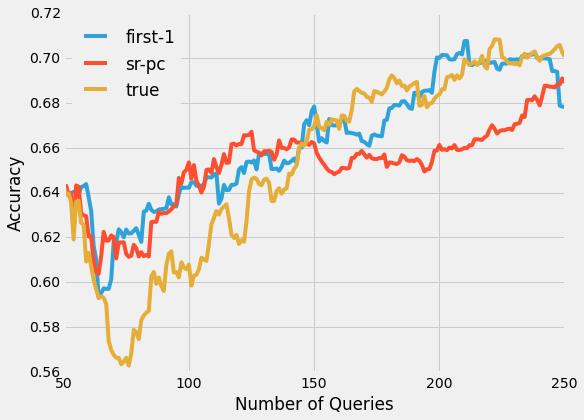

In [61]:
plot_eval([x,x,x], [y_f1, y_sr, y_true], labels=['first-1','sr-pc', 'true'], name='user_study.pdf')

# Evaluating Other Classifiers 

Try other classifiers with the same data as the student evaluation from the user study. Does a different classifier perform better than lrl1? 

The data representation doesn't change. binary BOW. 


Classifiers to try: 

* lr-l1 with other c values 
* SVC with default paramters 
* MNB with alpha=1
* lr-l1 with class weights 

The following experiments use the following settings:

* classifier
* bootstrap: 50 
* step: 1
* labels: true labels 


## Evaluate Classifiers with True Labels

Use the same documents as in the user study and use the true labels to see if they make a difference. Also, test with the human labels and observe the differences. 

In [17]:
#Evaluate MNB
print "EValuating MNB"
train_target= bt_true[:50]
train_target.extend(sr_true)
x, y_mnb = evaluate_student('mnb',train_bow, train_target,imdb.test, parameter=.5)

#Evaluate lrl1-C=100
print "Evaluating LR"
train_target= bt_true[:50]
train_target.extend(sr_true)
x, y_l110 = evaluate_student('lrl1',train_bow, train_target,imdb.test,parameter=100)

#Evaluate SVC 
# train_target= bt_true[:50]
# train_target.extend(sr_true)
# x, y_svc = evaluate_student('svc',train_bow, train_target,imdb.test,parameter=10)

#Evaluate class weighted LR
print "Evaluating CW"
train_target= bt_true[:50]
train_target.extend(sr_true)
x, y_cw = evaluate_student('lr-cw',train_bow, train_target,imdb.test, parameter=1)



EValuating MNB
Evaluating LR
Evaluating CW


## Test Human Labels 

Using mnb, lr with various options

# Evaluate Order of Experiments

We tried 100 random orderings of the user study labels and measure the proportion of runs that are first-1 and SR wins. 



In [59]:
print [sr_expert[sr_index.index(i)] for i in f1_index][:10]


[1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 2.0]


In [ ]:
def try_ordering(clf_name, train_bow, bt_target, true_target, f1_target, test, parameter=1, runs=100):
    
    results = []
    curves = []
    for i in range(runs):  
        order = np.random.RandomState(i * 10)
        
        order2 = order.choice(200, 200, replace=False) + 50  ## adjust for bootstrap
        order = np.append(range(50), order2)
        #Evaluate class weighted f1
        train_target= bt_target[:50]
        train_target.extend(f1_target)
        x, f1 = evaluate_student(clf_name,train_bow[order], np.array(train_target)[order],test, parameter=parameter)

        #Evaluate class weighted true
        train_target= bt_target[:50]
        train_target.extend(true_target)
        x, tr = evaluate_student(clf_name,train_bow[order], np.array(train_target)[order],test, parameter=parameter)
        
        print "run", i, len(f1), len(tr), stats.ttest_ind(f1, tr)
        results.append(stats.ttest_ind(f1, tr))
        curves.append([f1,tr])
    print "first-1 wins", len([a[1] for a in results if a[1] < 0.05 and a[0] > 0]) ## f1 wins  
    print "True wins",  len([a[1] for a in results if a[1] < 0.05 and a[0] < 0])
    return results, curves
    
# runs, curves = try_ordering('lr-cw', train_bow, bt_true[:50], sr_true, f1_target, imdb.test, parameter=1, runs=100)
runs2, curves2 = try_ordering('lrl1', train_bow, bt_true[:50], sr_true, f1_target, imdb.test, parameter=1, runs=100)


In [126]:
print "first-1 wins", len([a[1] for a in runs if a[1] >= 0.05 ])
print 55+15+30

first-1 wins 30
100


In [115]:
train_target= bt_true[:50]
train_target.extend(sr_true)
rnd_test = np.random.RandomState(1)
orderx = rnd_test.choice(200,200,replace=False) + 50

order=np.append(range(50), orderx)

train_target= bt_true[:50]
train_target.extend(f1_target)
# x, f1 = evaluate_student('lr-cw',train_bow[order], np.array(train_target)[order],imdb.test, parameter=1)

train_target= bt_true[:50]
train_target.extend(sr_true)
# x, tr = evaluate_student('lr-cw',train_bow[order], np.array(train_target)[order],imdb.test, parameter=1)

print stats.ttest_ind(f1, tr)
        

(3.6958965478032786, 0.00024963824769042795)


In [60]:

# Testing several classifiers 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

train_target= bt_true[:50]
train_target.extend(f1_target)
print "=== FIRST-1 LABELS ==="
# nb = get_classifier('svc',100)
# nb.fit(train_bow, train_target)
# print metrics.accuracy_score(imdb.test.target, nb.predict(imdb.test.bow))
nb = MultinomialNB(alpha=.50)
nb.fit(train_bow, train_target)
print "MNB:", metrics.accuracy_score(imdb.test.target, nb.predict(imdb.test.bow))

nb = LogisticRegression(class_weight={0:.45, 1:.55})
nb.fit(train_bow, train_target)
print "CW:", metrics.accuracy_score(imdb.test.target, nb.predict(imdb.test.bow))

nb = LogisticRegression(C=100)
nb.fit(train_bow, train_target)
print "LR-C=100", metrics.accuracy_score(imdb.test.target, nb.predict(imdb.test.bow))
# ============================================
train_target= bt_true[:50]
train_target.extend(sr_target)
print "=== SR-1 LABELS ==="

nb = MultinomialNB(alpha=.50)
nb.fit(train_bow, train_target)
print "MNB:", metrics.accuracy_score(imdb.test.target, nb.predict(imdb.test.bow))

nb = LogisticRegression(class_weight={0:.45, 1:.55})
nb.fit(train_bow, train_target)
print "CW:", metrics.accuracy_score(imdb.test.target, nb.predict(imdb.test.bow))

nb = LogisticRegression(C=100)
nb.fit(train_bow, train_target)
print "LR-C=100", metrics.accuracy_score(imdb.test.target, nb.predict(imdb.test.bow))

# ============================================
train_target= bt_true[:50]
train_target.extend(sr_true)
print "=== TRUE LABELS ==="

nb = MultinomialNB(alpha=.50)
nb.fit(train_bow, train_target)
print "MNB:", metrics.accuracy_score(imdb.test.target, nb.predict(imdb.test.bow))

nb = LogisticRegression(class_weight={0:.45, 1:.55})
nb.fit(train_bow, train_target)
print "CW:", metrics.accuracy_score(imdb.test.target, nb.predict(imdb.test.bow))

nb = LogisticRegression(C=100)
nb.fit(train_bow, train_target)
print "LR-C=100", metrics.accuracy_score(imdb.test.target, nb.predict(imdb.test.bow))

=== FIRST-1 LABELS ===
MNB: 0.691184121013
CW: 0.70811156909
LR-C=100 0.711633118572
=== SR-1 LABELS ===
MNB: 0.553483532754
CW: 0.726399615831
LR-C=100 0.72535915803
=== TRUE LABELS ===
MNB: 0.649045580055
CW: 0.760574652847
LR-C=100 0.756692944896


In [68]:
from scipy import stats
print "True vs. rest"
# print "t-statistic: %f, p-value: %f" % stats.ttest_ind(y_true, y_f1)
print "MNB: t-stat: %f, p-value: %f" % stats.ttest_rel(y_true, y_mnb)
print "LR-L1-C=10: t-stat: %f, p-value: %f" % stats.ttest_rel(y_true, y_l110)
# print "SVC: t-stat: %f, p-value: %f" % stats.ttest_rel(y_true, y_svc)

print "SVC: t-stat: %f, p-value: %f" % stats.ttest_rel(y_cw, f1_cw)
print "SVC: t-stat: %f, p-value: %f" % stats.ttest_rel(f1_cw, sr_cw)



True vs. rest
MNB: t-stat: 12.440929, p-value: 0.000000
LR-L1-C=10: t-stat: -34.576518, p-value: 0.000000
SVC: t-stat: -10.778611, p-value: 0.000000
SVC: t-stat: 25.124440, p-value: 0.000000


# Statistical Significance of the Results

Compare the three methods among each other to determine if the differences are significant

## Testing Oracle Accuracy on Full Training Set

# Annotation Time per Class - V2

We show the distribution of annotation per class (expert)

## Simulated Oracle Evaluation

Using a simulated oracle (with the same parameters as the paper) simulate the evaluation of the 

In [453]:

def evaluate_sim_student(clf, train_bow, bt_target, train_text, oracle, test, train, vct):
    import learner
    # train the student on the go
    sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')

    st = learner.strategy.StructuredLearner(clf)
    st.set_sent_tokenizer(sent_tk)
    st.set_vct(vct)
    st.set_snippet_utility('sr')
    st.set_calibration_method("zscores_pred")
   
    x = range(50, 251, 1)
    accuracy = []
    target_y = []
    rnd = np.random.RandomState(123)
    
    target = []
    target.extend(bt_target)
    
    for step in x: 
        if step == 50:
            ## Boostrap
            target_y = np.array(target[:step])
            train_x = train_bow[:step]
            # there are no neutrals here
            st.fit(train_x, target_y, doc_text=np.array(train_text))
        else:
            target_y = np.array(target[:step])
            train_x = train_bow[:step]

            non_neutral = target_y < 2

            st.fit(train_x[non_neutral], target_y[non_neutral], doc_text=np.array(train_text)[non_neutral])
            
            #Get a random pool for calibration + current document
            test_text = [train_text[step-1]]
            perm = rnd.permutation(len(train.data))
            test_text.extend(train.data[:249])
            
            ## compute the max scoring snippet (with calibration)
            _, snippet_text = st._compute_snippet(test_text)

            # Get the label from the oracle, add to targets
            query = vct.transform([snippet_text[0]])
            ora_target = oracle.predict(query)
            probs = oracle.predict_proba(query)
            unc = 1. - probs.max(1)
            neutral = unc > .4
            ora_target[neutral] = 2

            target.extend(ora_target)                      


            # Evaluate student and save result
            predicted = st.model.predict(test.bow)
            acc = metrics.accuracy_score(test.target, predicted)
            accuracy.append(acc)
    #         print step, acc

    return x, accuracy, target_y


In [454]:
train_text = bt_text[:50]
train_text= np.append(train_text, sr_text)
train_text = np.array([t.decode('utf-8') for t in train_text])
clf = exputil.get_classifier('lrl1', parameter=1)
x, simsr, simsr_target = evaluate_sim_student(clf, train_bow, bt_true[:50], train_text, sim_oracle, imdb.test, imdb.train, vct)

In [149]:
# Get SR snippets
doc_text, snip_text = read_text(DATA + "/imdb-rnd-sr-expert1-labels.txt")
snip_bow = vct.transform(snip_text)


#Evaluate simulated
simsr_target= bt_true[:50]

train_y = sim_oracle.predict(snip_bow)
probs = sim_oracle.predict_proba(snip_bow)
unc = 1. - probs.max(1)
neutral = unc > .4
train_y[neutral] = 2
simsr_target.extend(train_y)

# x, sim_sr = evaluate_student(clf,train_bow, simsr_target, imdb.test)
x, sim_sr = evaluate_student(clf,train_bow, simsr_target, imdb.test)





Number of fields: 7
Number of records: 200


In [150]:
# Get F1 snippets
doc_text, snip_text = read_text(DATA + "/imdb-rnd-first1-expert2-labels.txt")
snip_bow = vct.transform(snip_text)


#Evaluate simulated
simf1_target= bt_true[:50]
train_y = sim_oracle.predict(snip_bow)
probs = sim_oracle.predict_proba(snip_bow)
unc = 1. - probs.max(1)
neutral = unc > .4
train_y[neutral] = 2  #targets by oracle

#reorder targets based on sequence
new_target = [train_y[f1_index.index(i)] for i in sr_index]
simf1_target.extend(new_target)

x, sim_f1 = evaluate_student(clf,train_bow, simf1_target, imdb.test)




Number of fields: 7
Number of records: 200


In [502]:
def plot_evaluation(x_axis, y_axis, labels, class_dist, name='simulated.png'):
    ## Plot student evaluation with simulated and study
    fig = plt.figure(figsize=(8,6))
    colors_n = brewer2mpl.get_map('Set1', 'qualitative', 8).mpl_colors[:len(x_axis)]

    i = 0
    for x, y, l in zip(x_axis, y_axis, labels):
        plt.plot(x,y,label=l, color=colors_n[i])
        i +=1
   
    plt.ylabel("Accuracy")
    plt.ylim([.55,.75])
    plt.legend(loc='best')
    plt.title("Student Accuracy")

    ## Create a secondary y-axis
    ax = plt.axes()
    ax2 = ax.twinx()
    ax2.plot(x, class_dist, 'k--',label='true-dist')
    # ax2.plot([50,250], [.5,.5], '--',label='50%')
    ax2.set_ylabel('Class Distribution %')
    plt.ylim([0,1]) ## affects 2nd axis

    plt.xlabel("Number of Queries")

    plt.savefig(name,bbox_inches="tight", dpi=200, transparent=True)



Average distribution 0.455, min=0.429, max=0.500


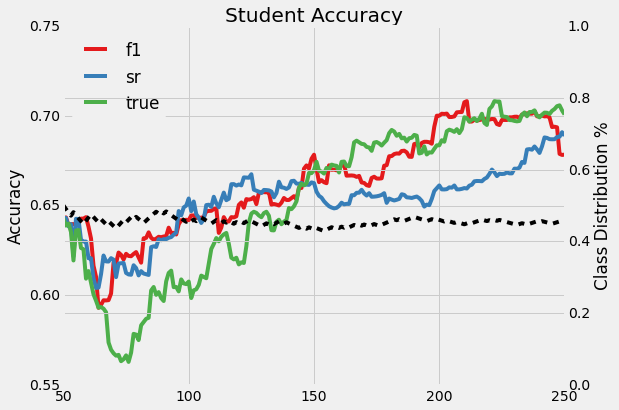

In [516]:
plot_evaluation([x,x,x], [y_f1, y_sr, y_true], ['f1','sr', 'true', 'sim-sr'], class_dist, name='sim_student.pdf')
print "Average distribution %.3f, min=%.3f, max=%.3f" % (class_dist.mean(), class_dist.min(), class_dist.max())



## Comparing Human vs. Simulated Evaluations

Using the user study labels compared to the simulated oracle labels

In [164]:
# SR vs SIM-SR targets
print "SR vs Sim-SR"
cm = metrics.confusion_matrix(sr_target, simsr_target[50:])
print 1.*cm.sum(0)/cm.sum()
print  "\n".join("\t".join([str(r) for r in row]) for row in cm)


print "Percent"
print  "\n".join("\t".join([str(r) for r in row]) for row in 1.*cm/cm.sum())

print "\nF1 vs Sim-F1"
cm = metrics.confusion_matrix(f1_target, simf1_target[50:])
print 1.*cm.sum(0)/cm.sum()
print  "\n".join("\t".join([str(r) for r in row]) for row in cm)

print "Percent"
print  "\n".join("\t".join([str(r) for r in row]) for row in 1.*cm/cm.sum())




SR vs Sim-SR
[ 0.37  0.42  0.21]
59	13	17
6	52	7
9	19	18
Percent
0.295	0.065	0.085
0.03	0.26	0.035
0.045	0.095	0.09

F1 vs Sim-F1
[ 0.33  0.4   0.27]
45	12	17
7	44	15
14	24	22
Percent
0.225	0.06	0.085
0.035	0.22	0.075
0.07	0.12	0.11


In [ ]:
# SR vs SIM-SR targets
print "SR vs Sim-SR"
cm = metrics.confusion_matrix(sr_target, simsr_target[50:])
print 1.*cm.sum(0)/cm.sum()
print 1.*cm.sum(1)/cm.sum()

print "\nF1 vs Sim-F1"
cm = metrics.confusion_matrix(f1_target, simf1_target[50:])
print 1.*cm.sum(0)/cm.sum()
print 1.*cm.sum(1)/cm.sum()



# Investigate Sentences 

Check for every document in the training set of the student: 

* first sentence
* best (sr) sentence
* longest sentence
* best (human) sentence 

In [663]:
def test_sentence_inv(train_text, snip_text, first_text, true_y, expert_y, n=1):
    sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')
    sent_text = sent_tk.tokenize_sents(t.decode('latin1') for t in train_text)
    snips = [t.decode('latin1') for t in snip_text]
    docs =[t.decode('latin1') for t in train_text]
    matches = []
    best = []
    i = 0
    for doc, snip, sents, t, e in zip(docs[:n], snips[:n], sent_text[:n], true_y[:n], expert_y[:n]):
        print i
        if snip in sents:
            print "Prueba 1, ok"
        if snip in doc:
            print "Prueba 2, ok"
        sr = sents.index(snip)
        best.append(sr)
        print "%s - %s" % (t,e)
#         print "\nfist-1:", sents[0]
#         print "\nSR:", snip
        lens = [len(s.split()) for s in sents]
        longest = np.argmax(lens)
        print "SR = LO", sr == longest
        
        matches.append([sr ==0, sr == longest])
#         print "\nLongest: (%s) - %s" % (lens[longest], sents[longest])
        print "\nDoc:"
        print doc
        print 
        for j, s in enumerate(sents):
            print "%s - %s" % (j,s)
        
        print "*--"*20
        i +=1
    return matches, best
       


## Testing other sentence picking methods

Try different ways pick sentences for the labes of the oracle:


In [ ]:
vct_counts = CountVectorizer(encoding='ISO-8859-1', min_df=1, max_df=1.0, binary=False, ngram_range=(1, 1),
                  token_pattern='\\b\\w+\\b')

vct_counts.fit_transform(imdb.train.data)        



In [208]:
doc_text, snip_text = read_text(DATA + "/imdb-rnd-sr-expert1-labels.txt")

Number of fields: 7
Number of records: 200


In [204]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import copy

from scipy.sparse import vstack

def add_instance(mat, to_add):
    test_sent = mat
    if len(to_add) == 0: #.shape[0] == 0:
        return mat
    
    for instance in to_add:
        if isinstance(test_sent, list):
            test_sent = instance
        else:
            test_sent = vstack([test_sent, instance], format='csr')
    return test_sent

def convert_bow(text, vct):
    bow = vct.transform(text)
    res = []
    fixed = (25. / bow.sum(1)).getA1()
    rows = []
    for i, val in enumerate(fixed):
        rows.append(bow[i] * val)
        
    res = add_instance([], rows)
    return res

test =  ['the worst movie i have ever seen','It is a great movie']
t2 = vct_counts.transform(test)
conv = convert_bow(test,vct_counts)


In [209]:
def pick_normilized(doc_text, clf, vct):
    ''' Given a document select the sentences based on normilized representation'''
    docx = convert_bow(doc_text, vct)
    probs = clf.predict_proba(docx)
    maxdoc = probs.argmax()[::-1]
    return maxdoc[0]

def train_normalized(clf, doc_text, target, vct):
    ''' Train a classifier using normilized sentences to select snippets'''
    
    sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')
    doc_sent = sent_tk.tokenize_sents([t.decode('latin1') for t in doc_text])

    sent_target = []
    train = []
    for d,t in zip(doc_sent,target):
        sent_target.extend([t] * len(d))
        train.extend(d)
    sent_target = np.array(sent_target)
    bow = vct.transform(train)
    
    return clf.fit(bow, sent_target)

def run_normalized(clf, docs, target, vct):
    '''Given a set of documents select the best sentence for each
    
    param: clf: normilized trained classifier
    param: docs: document sentences 
    param: vct: count vectorizer
    '''
    
    sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')
    res = []
    i = 0
    for d,t in zip(docs,target):
        sents = sent_tk.tokenize_sents(d)
        pick = pick_normilized(sents,clf, vct)
        res.append(pick)
        print i, pick, len(d)
        i += 1
    return res

train_target= bt_true[:50]
train_target.extend(sr_target)
clf_norm = get_classifier('lrl1', 1)
    
## Train classifier with only bootstrap
clf_norm = train_normilized(clf_norm, train_tx[:50], train_target[:50], vct_counts)

res = run_normalized(clf_norm,doc_text, sr_true , vct_counts)


UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 7: ordinal not in range(128)

In [664]:
matches, sr_picks = test_sentence_inv(doc_text, snip_text,None, sr_true, sr_expert, n=200)

0
Prueba 1, ok
Prueba 2, ok
0.0 - 2.0
SR = LO False

Doc:
I have yet to read Shirley Jackson's novel, something of which I've been meaning to do for quite sometime. I am sure it has got to be scarier than this film. I remember jumping once when I watched it the other day, although I cannot recall the scene.   The special effects are great and I watched this on DVD, but I am sure in the theatre it must have been an awesome sight. After the first few special effects are done with I was waiting for a story to develop.  I figured this movie at the least has to be loosely based on the classic novel, so a good story should be there, but it wasn't. I was relegated to staring at the gorgeous Catherine Zeta-Jones character throughout the movie basically because there was nothing much else to watch. Lili Talor was such a suck character. I did not like her one bit, something about whiny people. Also, the guy in this film reminded me of the cartoonish Dudley DoRight with his voice and face. I coul

In [1]:
match_f1 = [x[0] for x in matches]
match_lo = [x[1] for x in matches]

NameError: name 'matches' is not defined

In [656]:
print "match f1:", 1. * np.sum(match_f1)/len(match_f1)
print "match longest:", 1. * np.sum(match_lo)/len(match_f1)

match f1: 0.11
match longest: 0.215
